In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import missingno as msno
from datetime import date
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df



In [4]:
df=pd.read_csv("/content/diabetes.csv")
df.columns = [col.upper() for col in df.columns]

In [5]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [7]:
df.groupby("OUTCOME")[num_cols].mean()


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
OUTCOME,,,,,,,,
0,3.298,109.980,68.184,19.664,68.792,30.304,0.430,31.190
1,4.866,141.257,70.825,22.164,100.336,35.143,0.550,37.067


In [8]:
df["OUTCOME"].value_counts()*100/len(df["OUTCOME"])

0   65.104
1   34.896
Name: OUTCOME, dtype: float64

In [9]:
for col in num_cols:
    print(col, check_outlier(df, col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [10]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


<Axes: >

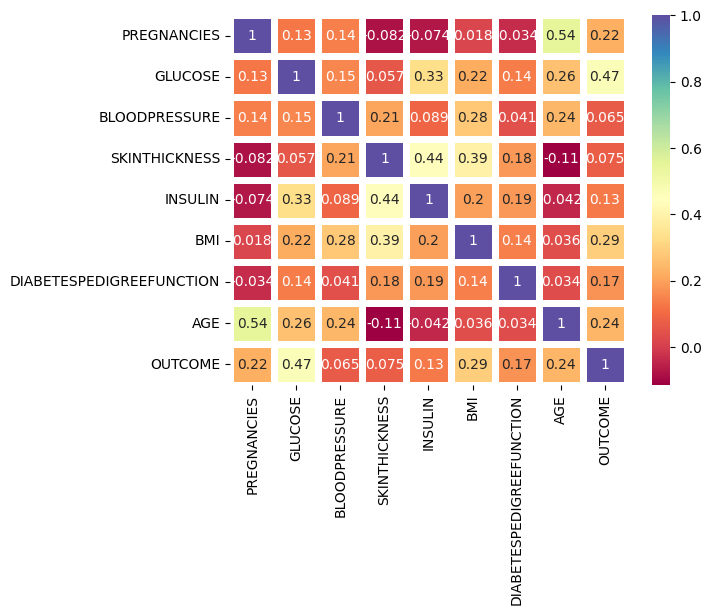

In [11]:
sns.heatmap(df.corr(),cmap="Spectral",annot=True,linewidth=5.)

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PREGNANCIES,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
GLUCOSE,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BLOODPRESSURE,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SKINTHICKNESS,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
INSULIN,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DIABETESPEDIGREEFUNCTION,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
AGE,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
OUTCOME,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [13]:
df[['GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION']]=df[['GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION']].replace({0:np.nan})

In [14]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [15]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [16]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,0.353,0.671,0.490,0.304,NaN,0.315,0.234,0.483,1.000
1,0.059,0.265,0.429,0.239,NaN,0.172,0.117,0.167,0.000
2,0.471,0.897,0.408,NaN,NaN,0.104,0.254,0.183,1.000
3,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0.000
4,0.000,0.600,0.163,0.304,0.185,0.509,0.944,0.200,1.000


In [17]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,0.353,0.671,0.490,0.304,0.385,0.315,0.234,0.483,1.000
1,0.059,0.265,0.429,0.239,0.051,0.172,0.117,0.167,0.000
2,0.471,0.897,0.408,0.274,0.269,0.104,0.254,0.183,1.000
3,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0.000
4,0.000,0.600,0.163,0.304,0.185,0.509,0.944,0.200,1.000


In [18]:
df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)

In [19]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6.000,148.000,72.000,35.000,334.200,33.600,0.627,50.000,1.000
1,1.000,85.000,66.000,29.000,56.200,26.600,0.351,31.000,0.000
2,8.000,183.000,64.000,32.200,238.000,23.300,0.672,32.000,1.000
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0.000
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1.000


In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PREGNANCIES,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
GLUCOSE,768.000,121.673,30.527,44.000,99.000,117.000,141.000,199.000
BLOODPRESSURE,768.000,72.307,12.184,24.000,64.000,72.000,80.000,122.000
SKINTHICKNESS,768.000,29.104,9.435,7.000,22.950,29.000,35.000,99.000
INSULIN,768.000,153.339,98.293,14.000,89.200,130.000,188.800,846.000
BMI,768.000,32.418,6.900,18.200,27.400,32.150,36.600,67.100
DIABETESPEDIGREEFUNCTION,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
AGE,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
OUTCOME,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [21]:
df.loc[df["AGE"] < 24, "AGE_BIN"] = "YOUNG"
df.loc[(df["AGE"] >= 24) & (df["AGE"] < 45), "AGE_BIN"] = "MATURE"
df.loc[df["AGE"] >= 45, "AGE_BIN"] = "OLD"

df.loc[df["BLOODPRESSURE"] < 64, "BLOOD_BIN"] = "LOW"
df.loc[(df["BLOODPRESSURE"] >= 64) & (df["BLOODPRESSURE"] < 85), "BLOOD_BIN"] = "NORMAL"
df.loc[df["BLOODPRESSURE"] >= 85, "BLOOD_BIN"] = "HIGH"

df.loc[df["INSULIN"] < 70, "INS_BIN"] = "LOW"
df.loc[(df["INSULIN"] >= 70) & (df["INSULIN"] < 100), "INS_BIN"] = "NORMAL"
df.loc[df["INSULIN"] >= 100, "INS_BIN"] = "HIGH"

df.loc[df["BMI"] < 20, "BMI_BIN"] = "LOW"
df.loc[(df["BMI"] >= 20) & (df["BMI"] < 26), "BMI_BIN"] = "NORMAL"
df.loc[df["BMI"] >= 26, "BMI_BIN"] = "HIGH"

df.loc[df["GLUCOSE"] < 70, "GLUCOSE_BIN"] = "LOW"
df.loc[(df["GLUCOSE"] >= 70) & (df["GLUCOSE"] < 100), "GLUCOSE_BIN"] = "NORMAL"
df.loc[df["GLUCOSE"] >= 100, "GLUCOSE_BIN"] = "HIGH"


In [22]:
df.head(5)

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,AGE_BIN,BLOOD_BIN,INS_BIN,BMI_BIN,GLUCOSE_BIN
0,6.000,148.000,72.000,35.000,334.200,33.600,0.627,50.000,1.000,OLD,NORMAL,HIGH,HIGH,HIGH
1,1.000,85.000,66.000,29.000,56.200,26.600,0.351,31.000,0.000,MATURE,NORMAL,LOW,HIGH,NORMAL
2,8.000,183.000,64.000,32.200,238.000,23.300,0.672,32.000,1.000,MATURE,NORMAL,HIGH,NORMAL,HIGH
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0.000,YOUNG,NORMAL,NORMAL,HIGH,NORMAL
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1.000,MATURE,LOW,HIGH,HIGH,HIGH


In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
rare_analyser(df, "OUTCOME", cat_cols)

Observations: 768
Variables: 14
cat_cols: 6
num_cols: 8
cat_but_car: 0
num_but_cat: 1
AGE_BIN : 3
        COUNT  RATIO  TARGET_MEAN
MATURE    462  0.602        0.387
OLD       133  0.173        0.496
YOUNG     173  0.225        0.133


BLOOD_BIN : 3
        COUNT  RATIO  TARGET_MEAN
HIGH      112  0.146        0.464
LOW       166  0.216        0.205
NORMAL    490  0.638        0.371


INS_BIN : 3
        COUNT  RATIO  TARGET_MEAN
HIGH      525  0.684        0.474
LOW       119  0.155        0.050
NORMAL    124  0.161        0.105


BMI_BIN : 3
        COUNT  RATIO  TARGET_MEAN
HIGH      618  0.805        0.414
LOW        13  0.017        0.000
NORMAL    137  0.178        0.088


GLUCOSE_BIN : 3
        COUNT  RATIO  TARGET_MEAN
HIGH      573  0.746        0.443
LOW        11  0.014        0.000
NORMAL    184  0.240        0.076


OUTCOME : 2
       COUNT  RATIO  TARGET_MEAN
0.000    500  0.651        0.000
1.000    268  0.349        1.000




In [24]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

In [25]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,AGE_BIN_OLD,AGE_BIN_YOUNG,BLOOD_BIN_LOW,BLOOD_BIN_NORMAL,INS_BIN_LOW,INS_BIN_NORMAL,BMI_BIN_LOW,BMI_BIN_NORMAL,GLUCOSE_BIN_LOW,GLUCOSE_BIN_NORMAL
0,6.000,148.000,72.000,35.000,334.200,33.600,0.627,50.000,1.000,1,0,0,1,0,0,0,0,0,0
1,1.000,85.000,66.000,29.000,56.200,26.600,0.351,31.000,0.000,0,0,0,1,1,0,0,0,0,1
2,8.000,183.000,64.000,32.200,238.000,23.300,0.672,32.000,1.000,0,0,0,1,0,0,0,1,0,0
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0.000,0,1,0,1,0,1,0,0,0,1
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1.000,0,0,1,0,0,0,0,0,0,0


In [26]:
ms = MinMaxScaler()
df[num_cols] = ms.fit_transform(df[num_cols])

df[num_cols].head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
0,0.353,0.671,0.490,0.304,0.385,0.315,0.234,0.483
1,0.059,0.265,0.429,0.239,0.051,0.172,0.117,0.167
2,0.471,0.897,0.408,0.274,0.269,0.104,0.254,0.183
3,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000
4,0.000,0.600,0.163,0.304,0.185,0.509,0.944,0.200


In [27]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,AGE_BIN_OLD,AGE_BIN_YOUNG,BLOOD_BIN_LOW,BLOOD_BIN_NORMAL,INS_BIN_LOW,INS_BIN_NORMAL,BMI_BIN_LOW,BMI_BIN_NORMAL,GLUCOSE_BIN_LOW,GLUCOSE_BIN_NORMAL
0,0.353,0.671,0.490,0.304,0.385,0.315,0.234,0.483,1.000,1,0,0,1,0,0,0,0,0,0
1,0.059,0.265,0.429,0.239,0.051,0.172,0.117,0.167,0.000,0,0,0,1,1,0,0,0,0,1
2,0.471,0.897,0.408,0.274,0.269,0.104,0.254,0.183,1.000,0,0,0,1,0,0,0,1,0,0
3,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0.000,0,1,0,1,0,1,0,0,0,1
4,0.000,0.600,0.163,0.304,0.185,0.509,0.944,0.200,1.000,0,0,1,0,0,0,0,0,0,0


In [28]:
X_train=df.drop("OUTCOME",axis=1)
y_train=df["OUTCOME"]
import copy
import math

In [29]:

print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First five elements in X_train are:
    PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION   AGE  AGE_BIN_OLD  AGE_BIN_YOUNG  BLOOD_BIN_LOW  BLOOD_BIN_NORMAL  INS_BIN_LOW  INS_BIN_NORMAL  BMI_BIN_LOW  BMI_BIN_NORMAL  GLUCOSE_BIN_LOW  GLUCOSE_BIN_NORMAL
0        0.353    0.671          0.490          0.304    0.385 0.315                     0.234 0.483            1              0              0                 1            0               0            0               0                0                   0
1        0.059    0.265          0.429          0.239    0.051 0.172                     0.117 0.167            0              0              0                 1            1               0            0               0                0                   1
2        0.471    0.897          0.408          0.274    0.269 0.104                     0.254 0.183            0              0              0                 1            0               0  

In [30]:

print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (768, 18)
The shape of y_train is: (768,)
We have m = 768 training examples


In [31]:
def sigmoid(z):
    """
    Compute the sigmoid of z
​
    Args:
        z (ndarray): A scalar, numpy array of any size.
​
    Returns:
        g (ndarray): sigmoid(z), with the same shape as z

    """
    if(type(z) != list):
        return 1 / ( 1 + np.exp(-(z)) )
    g = []
    print(z)

    for idx in range(len(z)):
        g.append(1 / ( 1 + np.exp(-(z[idx])) ))


    return g

In [32]:
value = 0
print (f"sigmoid({value}) = {sigmoid(value)}")

sigmoid(0) = 0.5


In [33]:
print ("sigmoid([ -1, 0, 1, 2]) = " + str(sigmoid(np.array([-1, 0, 1, 2]))))

sigmoid([ -1, 0, 1, 2]) = [0.26894142 0.5        0.73105858 0.88079708]


In [34]:

def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value
      w : (array_like Shape (n,)) Values of parameters of the model
      b : scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost: (scalar)         cost
    """
    m, n = X.shape

    total_cost = 0
    for idx in range(m):

        model_prediction = 0
        for idx2 in range(n):
            model_prediction = model_prediction + (w[idx2] * X[idx][idx2])
        model_prediction = model_prediction + b
        model_prediction = sigmoid(model_prediction)
        total_cost += -(y[idx]) * np.log(model_prediction) - (1 - y[idx]) * np.log(1 - model_prediction)

    total_cost = total_cost / m

    return total_cost

In [35]:
X_train=X_train.values
m, n = X_train.shape
# Compute and display cost with w and b initialized to zeros
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))

Cost at initial w and b (zeros): 0.693


In [36]:

def compute_gradient(X, y, w, b, lambda_=None):
    """
    Computes the gradient for logistic regression

    Args:
      X : (ndarray Shape (m,n)) variable such as house size
      y : (array_like Shape (m,1)) actual value
      w : (array_like Shape (n,1)) values of parameters of the model
      b : (scalar)                 value of parameter of the model
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w.
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b.
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)
        err_i  = f_wb_i  - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m
    dj_db = dj_db/m



    return dj_db, dj_dw

In [37]:

# Compute and display gradient with w and b initialized to zeros
initial_w = np.zeros(n)
initial_b = 0.
dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w and b (zeros):{dj_db}' )
print(f'dj_dw at initial w and b (zeros):{dj_dw.tolist()}' )

dj_db at initial w and b (zeros):0.15104166666666666
dj_dw at initial w and b (zeros):[0.013212316176470557, 0.02899445564516129, 0.06436277636054426, 0.02285439311594202, 0.001971122546073721, 0.022715895535105668, 0.013687164193709083, 0.008561197916666681, 0.0006510416666666666, 0.08268229166666667, 0.06380208333333333, 0.08203125, 0.06966145833333333, 0.06380208333333333, 0.008463541666666666, 0.07356770833333333, 0.007161458333333333, 0.1015625]


In [38]:

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X :    (ndarray Shape (m, n) data, m examples by n features
      y :    (ndarray Shape (m,))  target value
      w_in : (ndarray Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)              Initial value of parameter of the model
      cost_function :              function to compute cost
      gradient_function :          function to compute gradient
      alpha : (float)              Learning rate
      num_iters : (int)            number of iterations to run gradient descent
      lambda_ : (scalar, float)    regularization constant

    Returns:
      w : (ndarray Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """

    # number of training examples
    m = len(X)

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []

    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)
        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw
        b_in = b_in - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")

    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [44]:
np.random.seed(1)
initial_w = 0.2 * (np.random.rand(18)*0.5)
initial_b = -8
# Some gradient descent settings
iterations = 5000

alpha = 0.01
w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b,
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     2.73   
Iteration  500: Cost     1.17   
Iteration 1000: Cost     0.60   
Iteration 1500: Cost     0.55   
Iteration 2000: Cost     0.52   
Iteration 2500: Cost     0.51   
Iteration 3000: Cost     0.49   
Iteration 3500: Cost     0.48   
Iteration 4000: Cost     0.48   
Iteration 4500: Cost     0.47   
Iteration 4999: Cost     0.47   


In [45]:
# UNQ_C4
# GRADED FUNCTION: predict
def predict(X, w, b):
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w

    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model
​
    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape
    p = np.zeros(m)

    ### START CODE HERE ###
    # Loop over each example
    for i in range(m):
        z_wb = np.dot(X[i],w)
        # Loop over each feature
        for j in range(n):
            # Add the corresponding term to z_wb
            z_wb += 0

        # Add bias term
        z_wb += b

        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)
        # Apply the threshold
        p[i] = 1 if f_wb>0.5 else 0

    ### END CODE HERE ###
    return p

In [46]:
#Compute accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 76.171875
